## Import Library

In [11]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [12]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [13]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

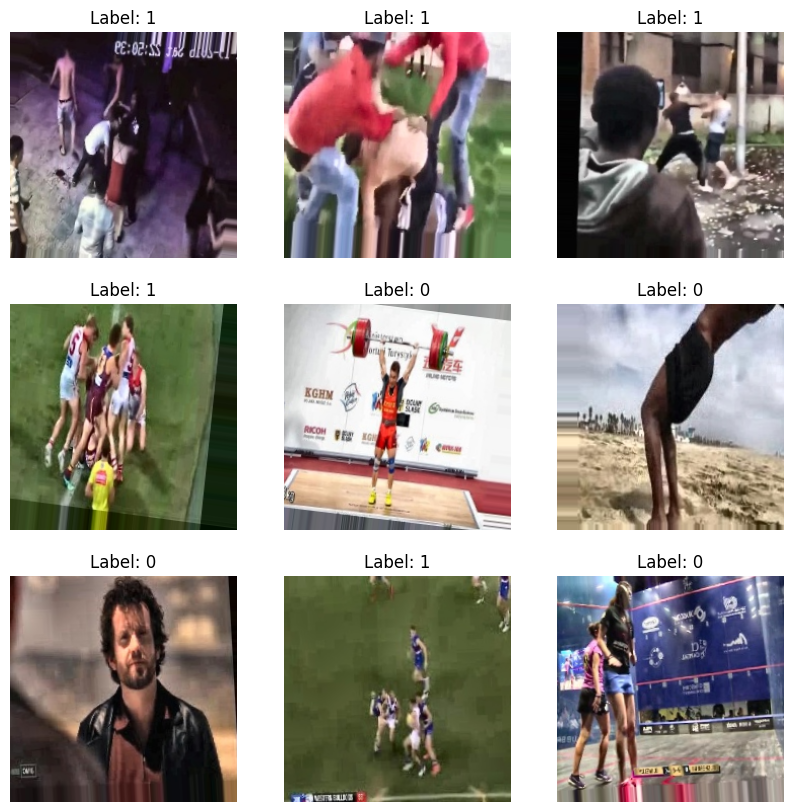

In [14]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [15]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze20_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7061 - loss: 1.1228
Epoch 1: val_accuracy improved from -inf to 0.65227, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 631ms/step - accuracy: 0.7070 - loss: 1.1198 - val_accuracy: 0.6523 - val_loss: 0.9335
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8408 - loss: 0.7281
Epoch 2: val_accuracy did not improve from 0.65227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.8411 - loss: 0.7275 - val_accuracy: 0.5045 - val_loss: 0.9960
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8735 - loss: 0.6343
Epoch 3: val_accuracy improved from 0.65227 to 0.73864, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.8734 - loss: 0.6345 - val_accuracy: 0.7386 - val_loss: 0.7873
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8917 - loss: 0.5750
Epoch 4: val_accuracy did not improve from 0.73864
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 571ms/step - accuracy: 0.8916 - loss: 0.5755 - val_accuracy: 0.7000 - val_loss: 0.7953
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8856 - loss: 0.5586
Epoch 5: val_accuracy improved from 0.73864 to 0.80227, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.8855 - loss: 0.5590 - val_accuracy: 0.8023 - val_loss: 0.6715
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8893 - loss: 0.5243
Epoch 6: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 549ms/step - accuracy: 0.8892 - loss: 0.5246 - val_accuracy: 0.7773 - val_loss: 0.7385
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8894 - loss: 0.5117
Epoch 7: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8896 - loss: 0.5115 - val_accuracy: 0.7705 - val_loss: 0.7267
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8978 - loss: 0.4964
Epoch 8: val_accuracy improved from 0.80227 to 0.88409, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8977 - loss: 0.4966 - val_accuracy: 0.8841 - val_loss: 0.5299
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8954 - loss: 0.4719
Epoch 9: val_accuracy improved from 0.88409 to 0.89091, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 578ms/step - accuracy: 0.8954 - loss: 0.4721 - val_accuracy: 0.8909 - val_loss: 0.5318
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9149 - loss: 0.4401
Epoch 10: val_accuracy improved from 0.89091 to 0.89773, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 573ms/step - accuracy: 0.9147 - loss: 0.4405 - val_accuracy: 0.8977 - val_loss: 0.4609
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9195 - loss: 0.4509
Epoch 11: val_accuracy improved from 0.89773 to 0.91136, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 0.9193 - loss: 0.4511 - val_accuracy: 0.9114 - val_loss: 0.4483
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9029 - loss: 0.4579
Epoch 12: val_accuracy did not improve from 0.91136
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.9029 - loss: 0.4577 - val_accuracy: 0.9045 - val_loss: 0.4437
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9073 - loss: 0.4377
Epoch 13: val_accuracy improved from 0.91136 to 0.92727, saving model to MCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.9075 - loss: 0.4373 - val_accuracy: 0.9273 - val_loss: 0.3921
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9134 - loss: 0.4249
Epoch 14: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 607ms/step - accuracy: 0.9135 - loss: 0.4247 - val_accuracy: 0.9250 - val_loss: 0.4064
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9145 - loss: 0.4114
Epoch 15: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.9146 - loss: 0.4114 - val_accuracy: 0.9136 - val_loss: 0.4227
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9350 - loss: 0.3835
Epoch 16: val_accuracy did not improve from 0.92727
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.9349 - loss: 0.3835 - val_accuracy: 0.9250 - val_loss: 0.3977
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9384 - loss: 0.3606
Epoch 17: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.9376 - loss: 0.3621 - val_accuracy: 0.9341 - val_loss: 0.3995
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9322 - loss: 0.3655
Epoch 19: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.9323 - loss: 0.3653 - val_accuracy: 0.8182 - val_loss: 0.6411
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9361 - loss: 0.3723
Epoch 20: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 548ms/step - accuracy: 0.9359 - loss: 0.3725 - val_accuracy: 0.7636 - val_loss: 0.8221
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9320 - loss: 0.3752
Epoch 21: val_accuracy did not improve from 0.93409
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.9317 - loss: 0.3756 - val_accuracy: 0.8659 - val_loss: 0.5361
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9361 - loss: 0.3558
Epoch 22: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9327 - loss: 0.3259
Validation Loss: 0.34491950273513794
Validation Accuracy: 0.9272727370262146


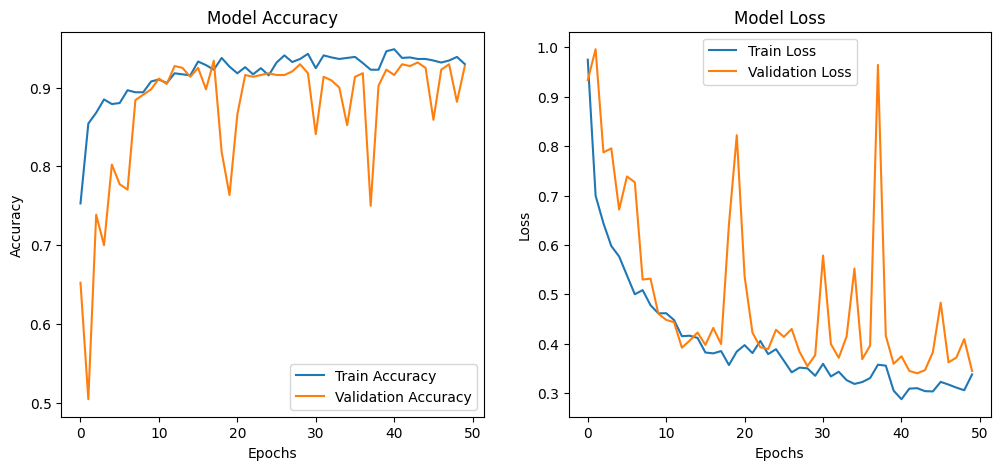

In [17]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [18]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze20_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.9029 - loss: 0.4344
Test Accuracy : 92.34%
Test Loss     : 0.387


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step


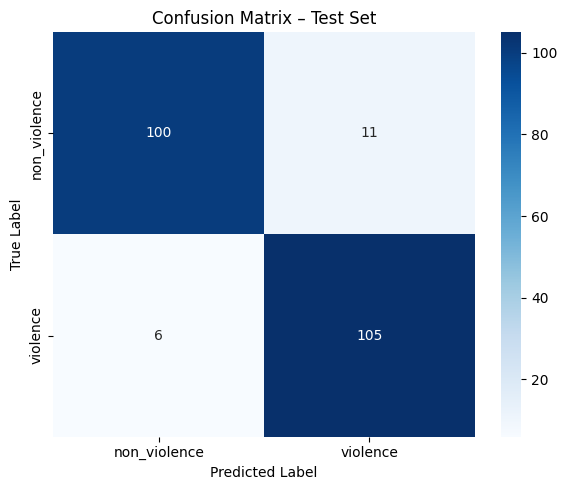


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.94      0.90      0.92       111
    violence       0.91      0.95      0.93       111

    accuracy                           0.92       222
   macro avg       0.92      0.92      0.92       222
weighted avg       0.92      0.92      0.92       222



In [19]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))